In [1]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [3]:
DATASET_DIR = "celiac_dataset"   # your folder with train/val/test
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
MODEL_SAVE = "vgg16_celiac_best.keras"

for sub in ['train', 'val', 'test']:
    path = os.path.join(DATASET_DIR, sub)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing folder: {path}")
print(" Dataset verified!")


 Dataset verified!


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(DATASET_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 64 images belonging to 2 classes.
Found 750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers initially
for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,980,418 (57.15 MB)

 Trainable params: 264,706 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [6]:
checkpoint = ModelCheckpoint(MODEL_SAVE, monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, early_stop, reduce_lr]


In [7]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.5169 - loss: 0.7693
Epoch 1: val_accuracy improved from None to 0.52133, saving model to vgg16_celiac_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 13s/step - accuracy: 0.5781 - loss: 0.7087 - val_accuracy: 0.5213 - val_loss: 0.6778 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.6211 - loss: 0.5904
Epoch 2: val_accuracy improved from 0.52133 to 0.61467, saving model to vgg16_celiac_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 13s/step - accuracy: 0.6406 - loss: 0.5756 - val_accuracy: 0.6147 - val_loss: 0.6606 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.6719 - loss: 0.4749
Epoch 3: val_accuracy improved from 0.61467 to 0.78000, saving model to vgg16_celiac_best.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 45s 15s/step - accuracy: 0.7188 - loss: 0.4505 - val_accuracy: 0.7800 - val_loss: 0.6462 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

In [8]:
# Unfreeze last 4 convolutional layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.8516 - loss: 0.2592
Epoch 1: val_accuracy did not improve from 0.84800
4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 14s/step - accuracy: 0.8750 - loss: 0.2751 - val_accuracy: 0.8480 - val_loss: 0.6163 - learning_rate: 1.0000e-05
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.9076 - loss: 0.2176
Epoch 2: val_accuracy did not improve from 0.84800
4/4 ━━━━━━━━━━━━━━━━━━━━ 41s 13s/step - accuracy: 0.8906 - loss: 0.2247 - val_accuracy: 0.8387 - val_loss: 0.6097 - learning_rate: 1.0000e-05
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.9297 - loss: 0.2122
Epoch 3: val_accuracy did not improve from 0.84800

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
4/4 ━━━━━━━━━━━━━━━━━━━━ 46s 15s/step - accuracy: 0.9375 - loss: 0.1915 - val_accuracy: 0.8200 - val_loss: 0.6049 - learning_rate: 1.0000e-05
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9596 - loss: 0.1676
Epoch 4: v

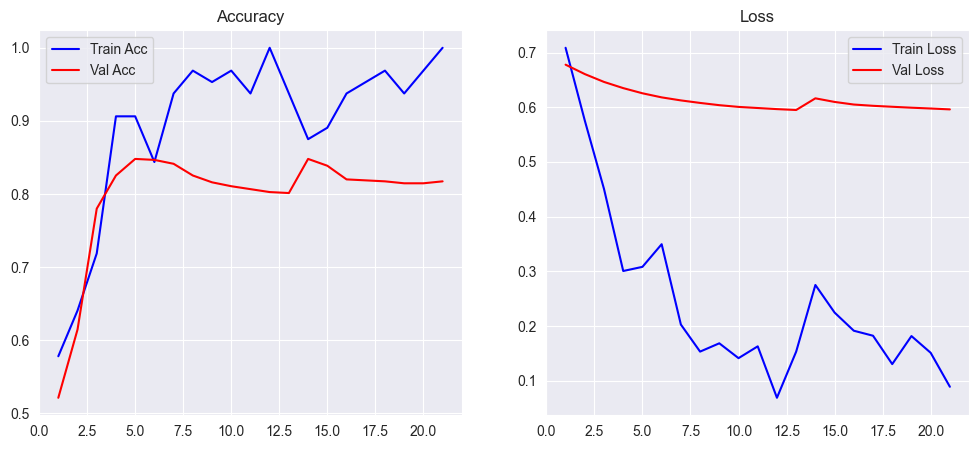

In [9]:
def plot_history(histories):
    acc, val_acc, loss, val_loss = [], [], [], []
    for h in histories:
        acc += h.history['accuracy']
        val_acc += h.history['val_accuracy']
        loss += h.history['loss']
        val_loss += h.history['val_loss']

    epochs = range(1, len(acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Train Acc')
    plt.plot(epochs, val_acc, 'r', label='Val Acc')
    plt.legend(); plt.title("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Val Loss')
    plt.legend(); plt.title("Loss")
    plt.show()

plot_history([history, history_fine])

In [10]:
model.load_weights(MODEL_SAVE)
test_loss, test_acc = model.evaluate(test_generator)
print(f" Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")


C:\Users\yadav\IdeaProjects\test\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9893 - loss: 0.5984
 Test Accuracy: 98.93% | Test Loss: 0.5984


47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 802ms/step - accuracy: 0.9893 - loss: 0.5984

 Test Accuracy: 98.93%
 Test Loss: 0.5984


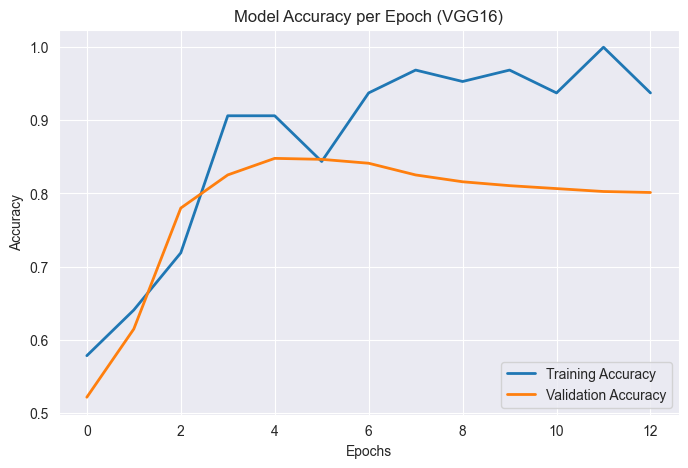

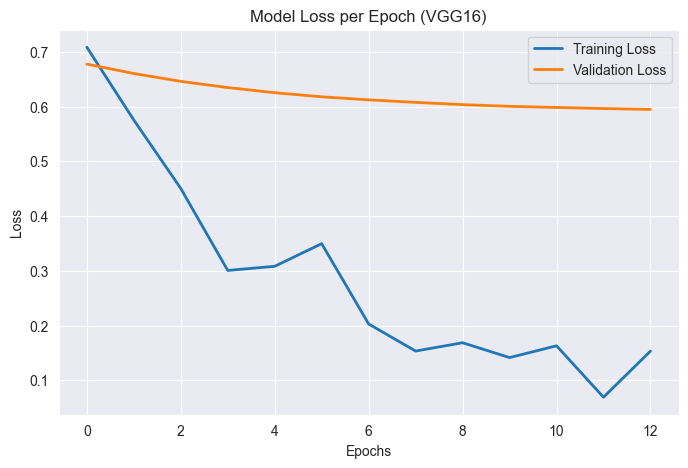

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss:.4f}")

# Step 2: Plot Training vs Validation Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy per Epoch (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Step 3: Plot Training vs Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss per Epoch (VGG16)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


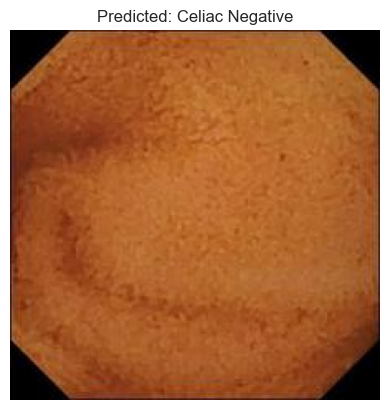

In [12]:
from tensorflow.keras.preprocessing import image

sample_path = test_generator.filepaths[0]
img = image.load_img(sample_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

plt.imshow(image.load_img(sample_path))
plt.title(f"Predicted: {class_labels[pred_class[0]]}")
plt.axis('off')
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test set
test_generator.reset()
pred = model.predict(test_generator, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)

# True labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_class_indices, target_names=class_labels))

# Confusion matrix
print("\n--- Confusion Matrix ---")
print(confusion_matrix(true_classes, predicted_class_indices))

# Overall accuracy
print("\nOverall Test Accuracy:", round(accuracy_score(true_classes, predicted_class_indices)*100, 2), "%")


47/47 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step

--- Classification Report ---
                 precision    recall  f1-score   support

Celiac Negative       0.98      1.00      0.99       375
Celiac Positive       1.00      0.98      0.99       375

       accuracy                           0.99       750
      macro avg       0.99      0.99      0.99       750
   weighted avg       0.99      0.99      0.99       750


--- Confusion Matrix ---
[[374   1]
 [  7 368]]

Overall Test Accuracy: 98.93 %


In [14]:
print("Classes:", test_generator.class_indices)
print("Number of test images:", len(test_generator.filepaths))


Classes: {'Celiac Negative': 0, 'Celiac Positive': 1}
Number of test images: 750


47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 814ms/step
                 precision    recall  f1-score   support

Celiac Negative       0.98      1.00      0.99       375
Celiac Positive       1.00      0.98      0.99       375

       accuracy                           0.99       750
      macro avg       0.99      0.99      0.99       750
   weighted avg       0.99      0.99      0.99       750

Overall Accuracy: 98.93 %


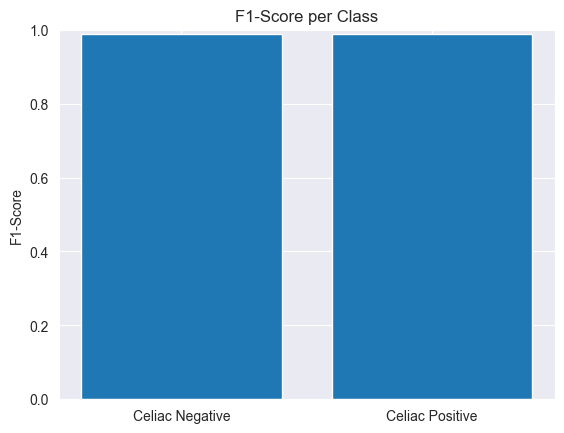

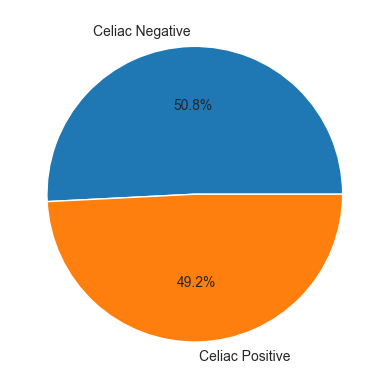

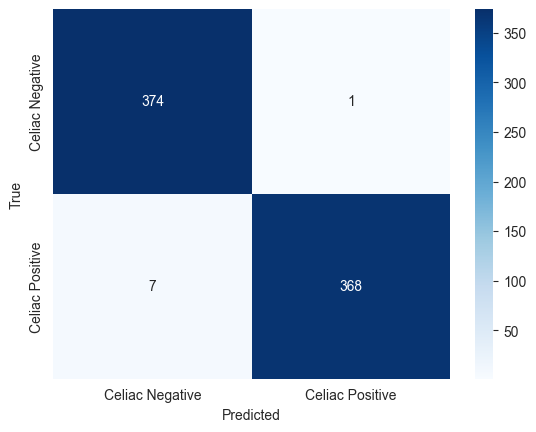

In [15]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_generator.reset()
pred = model.predict(test_generator, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- metrics ---
report = classification_report(true_classes, predicted_class_indices,
target_names=class_labels, output_dict=True)
print(classification_report(true_classes, predicted_class_indices, target_names=class_labels))
print("Overall Accuracy:", round(accuracy_score(true_classes, predicted_class_indices)*100,2), "%")

# --- bar chart ---
plt.bar(class_labels, [report[l]['f1-score'] for l in class_labels])
plt.title("F1-Score per Class"); plt.ylabel("F1-Score"); plt.ylim(0,1); plt.show()

# --- pie chart ---
unique, counts = np.unique(predicted_class_indices, return_counts=True)
plt.pie(counts, labels=[class_labels[i] for i in unique], autopct='%1.1f%%'); plt.show()

# --- confusion matrix ---
cm = confusion_matrix(true_classes, predicted_class_indices)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [16]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [18]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def find_vgg_base(model):
    """Return the inner VGG model if present, otherwise None."""
    for layer in model.layers:
        # look for a nested Functional model with 'vgg' in the name
        if isinstance(layer, tf.keras.Model) and 'vgg' in layer.name.lower():
            return layer
    return None

def list_conv_layers(model):
    """Return list of convolutional layers (name, output_shape) for diagnostics."""
    convs = []
    # if nested, inspect nested model too
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            for sub in layer.layers:
                if hasattr(sub, 'output_shape') and len(sub.output_shape) == 4:
                    convs.append((f"{layer.name}/{sub.name}", sub.output_shape))
        else:
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                convs.append((layer.name, layer.output_shape))
    return convs

def get_last_conv_layer(model):
    """Return the last conv layer object (search nested models first)."""
    # search nested VGG if present
    vgg_base = find_vgg_base(model)
    if vgg_base:
        for layer in reversed(vgg_base.layers):
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                return layer, f"{vgg_base.name}/{layer.name}"
    # fallback: search top-level layers
    for layer in reversed(model.layers):
        if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
            return layer, layer.name
    return None, None

def make_gradcam_heatmap(img_array, model, class_idx=None):
    """Compute Grad-CAM heatmap (returns 2D heatmap)."""
    # Ensure model graph is built
    _ = model.predict(img_array)

    last_conv_layer, last_conv_name = get_last_conv_layer(model)
    if last_conv_layer is None:
        # diagnostic info
        print("No conv layer found. Available conv-like layers:")
        for name, shape in list_conv_layers(model):
            print(" ", name, shape)
        raise ValueError("No convolutional layer found in model.")

    print(f"Using last conv layer for Grad-CAM: {last_conv_name}")

    # Build model: inputs -> [conv_outputs, predictions]
    # If last_conv is nested, need to use model.input but last_conv.output (works)
    grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weighted combination
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    return heatmap

def overlay_and_show(img_path, heatmap, out_path=None, alpha=0.4):
    """Overlay heatmap on image, show, and optionally save to out_path."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    hm = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    hm = np.uint8(255 * hm)
    hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 1 - alpha, hm, alpha, 0)
    rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

    if out_path:
        cv2.imwrite(out_path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        print(f"Saved: {out_path}")

def gradcam_for_image(img_path, model, class_names=None, save_dir=None):
    """Convenience wrapper: runs grad-cam for predicted class and optionally for all classes."""
    # Prepare input
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    arr = tf.keras.preprocessing.image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = tf.keras.applications.vgg16.preprocess_input(arr)

    preds = model.predict(arr)
    pred_idx = int(np.argmax(preds[0]))
    print("Predicted index:", pred_idx, "prob:", preds[0][pred_idx])
    if class_names:
        print("Predicted class name:", class_names[pred_idx])

    # Get single Grad-CAM for predicted class
    heatmap = make_gradcam_heatmap(arr, model, class_idx=pred_idx)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, f"gradcam_predicted_{os.path.basename(img_path)}")
    else:
        out_path = None
    overlay_and_show(img_path, heatmap, out_path)

    # If user wants all classes' maps, uncomment below:
    # for i, cname in enumerate(class_names):
    #     hm = make_gradcam_heatmap(arr, model, class_idx=i)
    #     out = None
    #     if save_dir:
    #         out = os.path.join(save_dir, f"gradcam_{cname}_{os.path.basename(img_path)}")
    #     overlay_and_show(img_path, hm, out)

# ===== Example usage (run these lines) =====
# class_names = list(test_generator.class_indices.keys())
# sample_img = test_generator.filepaths[5]   # change index if desired
# gradcam_for_image(sample_img, model, class_names, save_dir="gradcam_results")
